In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
tf.__version__
tf.random.set_seed(123)

In [2]:
# Adding data paths
parent_dir = r'E:\datasets\pneumonia_kaggle'
train_dir = os.path.join(parent_dir,'train')
test_dir = os.path.join(parent_dir,'test')
val_dir = os.path.join(parent_dir,'val')
save_dir = r'D:\Projects\Pneumonia Kaggle\model'

In [3]:
# Setting parameters
batch_size = 32
img_height = 450
img_width = 450

In [4]:
# Converting data directory to a training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [5]:
# Converting data directory to a validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 16 files belonging to 2 classes.


In [6]:
# Converting data directory to a test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width))

Found 624 files belonging to 2 classes.


In [7]:
# Getting x and y from the test set
x_test = []
y_test = []
for x,y in test_ds:
    # x_test.append(x)
    # y_test.append(y)
    x_test.extend(x.numpy())
    y_test.extend(y.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
# Getting class names
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


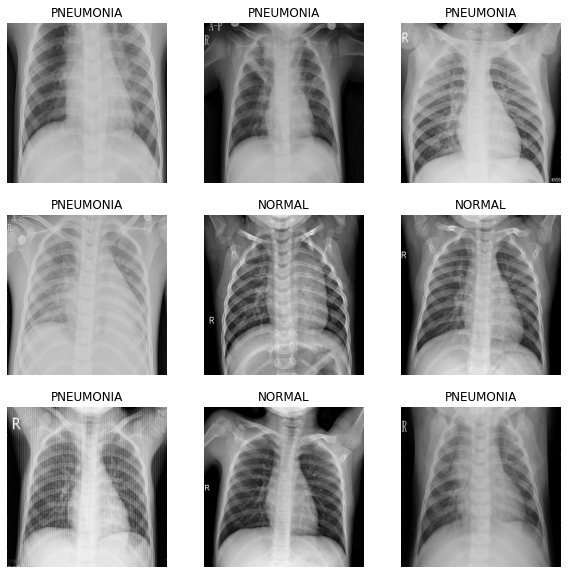

In [9]:
# Visualizing a data sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [10]:
# Normalizing colors
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9997755


In [11]:
# Structuring the model
num_classes = len(class_names)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=1, verbose=1)
model = keras.models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32,3, activation='relu', input_shape=(img_width,img_height,3)))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(32,3,activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

In [12]:
model.compile(
              optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])     #BinaryCrossentropy achieves poorer results

In [13]:
# Fitting the model
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=12,
                    callbacks=[callback])

Epoch 1/12
163/163 [==============================] - 1576s 9s/step - loss: 2.0366 - accuracy: 0.7573 - val_loss: 0.3316 - val_accuracy: 0.8125
Epoch 2/12
163/163 [==============================] - 1242s 8s/step - loss: 0.1090 - accuracy: 0.9577 - val_loss: 0.2135 - val_accuracy: 0.8750
Epoch 3/12
163/163 [==============================] - 1215s 7s/step - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.1449 - val_accuracy: 0.9375
Epoch 4/12
163/163 [==============================] - 1190s 7s/step - loss: 0.0970 - accuracy: 0.9655 - val_loss: 0.0764 - val_accuracy: 1.0000
Epoch 00004: early stopping


4

In [14]:
# Save model
model.save('{}\pneumonia_12e.h5'.format(save_dir))

In [15]:
# Getting predictions
preds = model.predict(x_test, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

In [16]:
# Checking that array shapes are correct
print(preds.shape)
print(y_test.shape)

(624,)
(624,)


In [17]:
# Assessing model performance using confusion matrix
from sklearn.metrics import confusion_matrix

cm  = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision * recall)/(precision + recall))

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1-score of the model is {:.2f}".format(f1))

Recall of the model is 1.00
Precision of the model is 0.72
F1-score of the model is 0.84
